In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import random
from pizzairnet import PizzairNet, ResidualBlock
from imitation_learning_dataloader import ImitationDataLoader

# training configuration

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#pizzair_model = PizzairNet(ResidualBlock, [3, 4, 6, 3])


# data loading

video_list_wd2 = ['wd2_brown',
              'wd2_city1',
              'wd2_city2',
              'wd2_office',
              'wd2_park1',
              'wd2_park2']
video_list_fh4 = ['fh4_edin',
              'fh4_park',
              'fh4_quarry',
              'fh4_train',
              'fh4_tree']
video_list_mix = ['wd2_city1',
              'wd2_office',
              'wd2_park2',
              'fh4_edin',
              'fh4_train',
              'fh4_tree']
video_list_test_wd2 = ['wd2_sub']
video_list_real = ['real_south']

vid_list_all_sim = video_list_wd2 + video_list_fh4

In [2]:
batch_size = 128

pizzair_model = PizzairNet(ResidualBlock, [2,2,2,2])
pizzair_model.to(device)
num_epochs = 100
optimizer = torch.optim.AdamW(pizzair_model.parameters(),lr=1e-3)

training_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # training
    pizzair_model.train()
    t_loss = 0.0
    t_num_correct = 0
    # need to "remake" it because it doens't reset as of now. oops 
    imitation_train_dataset = ImitationDataLoader(video_name_list=vid_list_all_sim,batch_size=batch_size)

    for X_train_batch,Y_train_batch in tqdm(imitation_train_dataset,desc='Epoch: '+str(epoch+1)):
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        
        optimizer.zero_grad()
        Y_train_hat = pizzair_model(X_train_batch)
        #print(Y_train_hat)
        #print(Y_train_batch)
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,epoch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

    training_losses[epoch]   = t_loss/(imitation_train_dataset.__len__()*batch_size)
torch.save(pizzair_model,'models/model_v2__wd2' +  '.pth')


Epoch: 74: 100%|██████████| 350/350 [01:55<00:00,  3.02it/s]


KeyboardInterrupt: 

In [3]:
torch.save(pizzair_model,'models/model_v2_all' +  '.pth')


In [5]:
### Fine-tuning script ### 
batch_size = 128

pizzair_model = torch.load('models/model_v2_all' +  '.pth')
pizzair_model.to(device)
num_epochs = 20
optimizer = torch.optim.AdamW(pizzair_model.parameters(),lr=1e-4)

training_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # training
    pizzair_model.train()
    t_loss = 0.0
    t_num_correct = 0
    # need to "remake" it because it doens't reset as of now. oops 
    imitation_train_dataset = ImitationDataLoader(video_name_list=video_list_real,batch_size=batch_size)

    for X_train_batch,Y_train_batch in tqdm(imitation_train_dataset,desc='Epoch: '+str(epoch+1)):
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        
        optimizer.zero_grad()
        Y_train_hat = pizzair_model(X_train_batch)
        #print(Y_train_hat)
        #print(Y_train_batch)
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,epoch+100)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

    training_losses[epoch]   = t_loss/(imitation_train_dataset.__len__()*batch_size)
torch.save(pizzair_model,'models/model_v2_all_ft' +  '.pth')


Epoch: 20: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


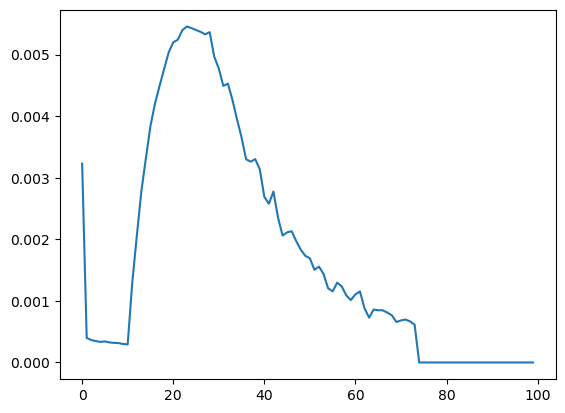

In [4]:
# plots training loss stuff
import matplotlib.pyplot as plt
plt.plot(range(len(training_losses)),training_losses)
np.save('train_loss_record.npy',training_losses)

In [8]:
batch_size = 128
imitation_train_dataset = ImitationDataLoader(video_name_list=video_list[0:6],batch_size=batch_size)
imitation_test_dataset = ImitationDataLoader(video_name_list=[video_list[6]],batch_size=batch_size)
pizzair_model = torch.load('models/pizzairnet_v1_checkpoint_100.pth')
pizzair_model.to(device)
pizzair_model.eval()
train_loss = 0.0
y_true = []
y_pred = []
with torch.inference_mode():
    for X_train_batch,Y_train_batch in tqdm(imitation_train_dataset,desc='Train'):
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        Y_train_hat = pizzair_model(X_train_batch)
        # adds relevant things
        #print(X_train_batch)
        #print(Y_train_hat[0][0],Y_train_hat[1][0],Y_train_hat[2][0])
        #print(Y_train_batch[0][0],Y_train_batch[0][1],Y_train_batch[0][2])
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,50)
        #optimizer.step()
        train_loss += loss.item()
    print('Train Loss:',train_loss/(imitation_train_dataset.__len__()*batch_size))
    test_loss = 0.0

    for X_train_batch,Y_train_batch in tqdm(imitation_test_dataset,desc='Test'):
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)

        Y_train_hat = pizzair_model(X_train_batch)
        #print(Y_train_hat)
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,50)
        test_loss += loss.item()
    print('Train Loss:',train_loss/(imitation_test_dataset.__len__()*batch_size))

Train: 100%|██████████| 192/192 [00:30<00:00,  6.30it/s]


Train Loss: 0.00900136136165012


Test: 100%|██████████| 42/42 [00:08<00:00,  5.07it/s]

Train Loss: 0.04114908051040055


In [3]:
torch.save(pizzair_model,'models/pizzairnet_v1_1_0.pth')